In [1]:
#!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as skMAPE
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df_2017 = pd.read_excel('M1_int_22-17.xlsx', sheet_name='2017', header=6)
df_2018 = pd.read_excel('M1_int_22-17.xlsx', sheet_name='2018', header=6)
df_2019 = pd.read_excel('M1_int_22-17.xlsx', sheet_name='2019', header=6)
df_2020 = pd.read_excel('M1_int_22-17.xlsx', sheet_name='2020', header=6)
df_2021 = pd.read_excel('M1_int_22-17.xlsx', sheet_name='2021', header=6)
df_2022 = pd.read_excel('M1_int_22-17.xlsx', sheet_name='2022', header=6) 

In [4]:
data = [df_2017,df_2018,df_2019,df_2020,df_2021,df_2022]

In [5]:
df_withna = pd.concat(data).reset_index().drop('index', axis=1)
df_withna.shape

(54781, 22)

In [6]:
def get_dates(df):
    dates = pd.to_datetime(((df.iloc[1::25,0]+' ')*24).str.split().explode().values, format="%d.%m.%Y")
    return dates

In [7]:
dates = get_dates(data[0]) # каждому периоду ставим в соответсвие дату (период = 1ч)
for df in data[1:]:
    dates = np.concatenate([dates, get_dates(df)])

In [8]:
dates.shape

(52584,)

In [9]:
df_nonan = df_withna.dropna().rename(columns={'Unnamed: 0': 'time', 'Unnamed: 1': 'total', 'Unnamed: 2': 'forward', 'Unnamed: 3': 'reverse', 'легковые': 'car_total', 'Unnamed: 5': 'car_forward', 'Unnamed: 6': 'car_reverse'})
df_nonan.shape

(52584, 22)

In [10]:
df_nonan.head() 

,time,total,forward,reverse,car_total,car_forward,car_reverse,"микроавтобусы, малые грузовики",Unnamed: 8,Unnamed: 9,...,Unnamed: 12,автопоезда до 13 м,Unnamed: 14,Unnamed: 15,автопоезда 13..18 м,Unnamed: 17,Unnamed: 18,длинные автопоезда свыше 18 м,Unnamed: 20,Unnamed: 21
2,00-01,86,47,39,63,35,28,4,4,0,...,0,0,0,0,7,6,1,11,1,10
3,01-02,135,84,51,105,64,41,5,4,1,...,1,1,0,1,13,11,2,10,5,5
4,02-03,178,132,46,163,121,42,9,7,2,...,2,1,1,0,1,1,0,1,1,0
5,03-04,165,119,46,151,113,38,9,3,6,...,0,1,0,1,0,0,0,4,3,1
6,04-05,142,89,53,119,73,46,15,11,4,...,0,0,0,0,1,1,0,6,3,3


# Visualization of total_forward

In [11]:
total_forward_for_period = pd.DataFrame({'date': dates, 'count': df_nonan['forward']})
total_forward_for_period.head()

,date,count
2,2017-01-01,47
3,2017-01-01,84
4,2017-01-01,132
5,2017-01-01,119
6,2017-01-01,89


In [12]:
sum_forward_within_day = total_forward_for_period.groupby('date').agg({'count': 'sum'})
sum_forward_within_day.head()

,count
date,
2017-01-01,6767
2017-01-02,13250
2017-01-03,13527
2017-01-04,11289
2017-01-05,10652


In [13]:
tf_week = sum_forward_within_day.resample('W', closed='left').sum()['count']
tf_week.head()

date
2017-01-08    69747
2017-01-15    58795
2017-01-22    68595
2017-01-29    70246
2017-02-05    74113
Freq: W-SUN, Name: count, dtype: int64

In [14]:
pd.DataFrame(tf_week)

,count
date,
2017-01-08,69747
2017-01-15,58795
2017-01-22,68595
2017-01-29,70246
2017-02-05,74113
...,...
2022-12-04,76660
2022-12-11,82246
2022-12-18,81385


In [15]:
#from pmdarima.model_selection import train_test_split

In [16]:
tf_train, tf_test = train_test_split(tf_week, test_size=53)
tf_train.tail(), tf_test.head()

(date
 2021-11-28    66950
 2021-12-05    78124
 2021-12-12    71291
 2021-12-19    75676
 2021-12-26    81985
 Freq: W-SUN, Name: count, dtype: int64,
 date
 2022-01-02    97555
 2022-01-09    67174
 2022-01-16    62903
 2022-01-23    67405
 2022-01-30    73309
 Freq: W-SUN, Name: count, dtype: int64)

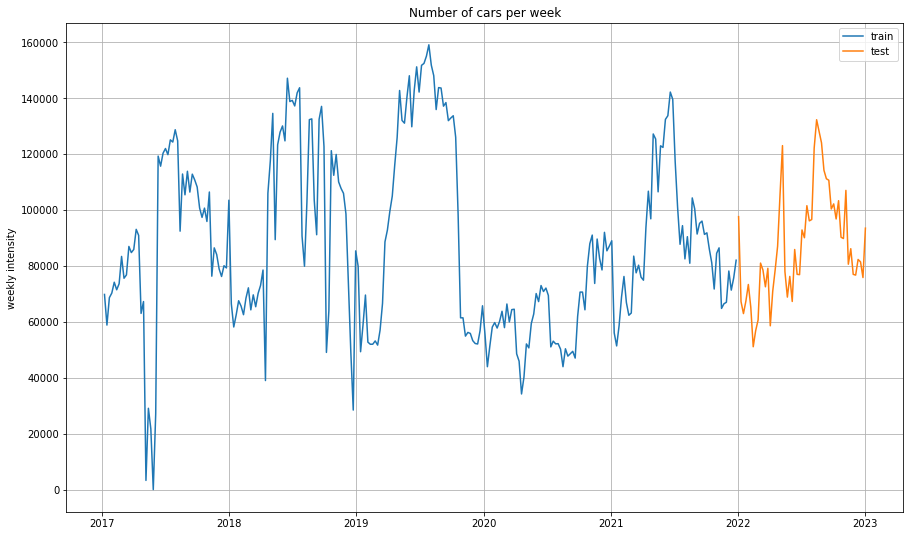

In [17]:
plt.figure(figsize=(15,9))
plt.grid()
plt.title('Number of cars per week')
plt.ylabel('weekly intensity')
plt.plot(tf_train, label='train')
plt.plot(tf_test, label='test')
plt.legend();

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    print('adf: ', adf)
    print('p-value: ', pvalue)
    print('Critical values: ', dftest[4])
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [20]:
check_stationarity(tf_train) # d=0

adf:  -3.710621553392006
p-value:  0.003966208909852497
Critical values:  {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}
The series is stationary


In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
def plot_acf_pacf(ts, lags=60):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(ts, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(ts, lags=lags, ax=ax2)

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


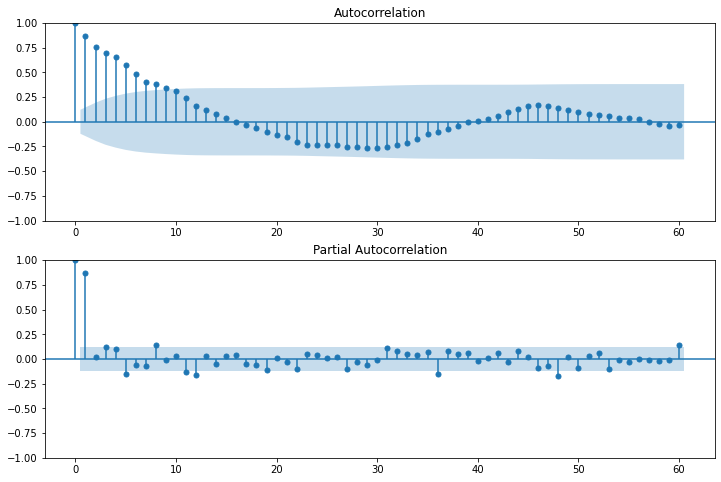

In [23]:
plot_acf_pacf(tf_train) # q in [5,6,7,8,9,10], p in [1,5,8,12,48]

In [24]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
p = 48
d = 0
q = 9
tf_model_fit = SARIMAX(tf_train, oder=(p,d,q), seasonal_order=(1,0,2,52)).fit()

n_test = tf_test.shape[0]
tf_predict = tf_model_fit.forecast(steps=n_test)

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


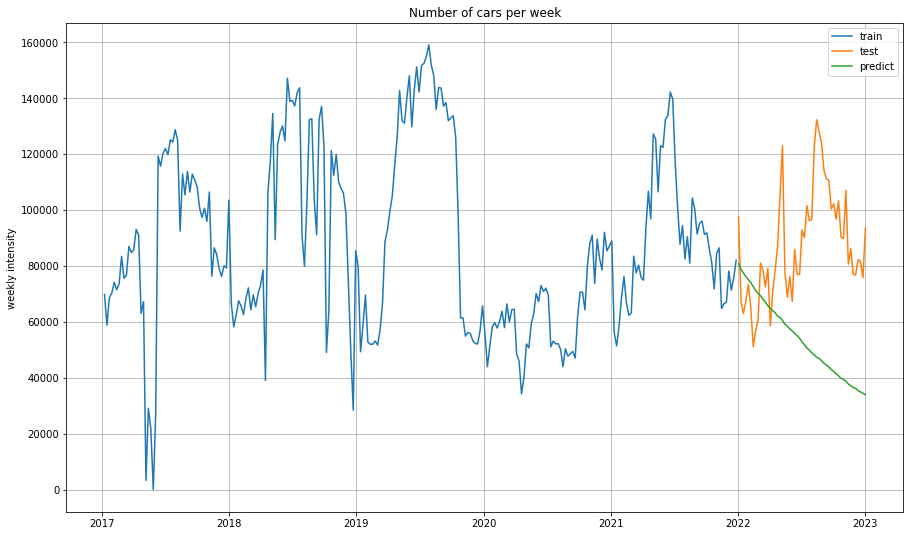

In [33]:
plt.figure(figsize=(15,9)) # переименовать
plt.grid()
plt.title('Number of cars per week')
plt.ylabel('weekly intensity')
plt.plot(tf_train, label='train')
plt.plot(tf_test, label='test')
plt.plot(tf_predict, label='predict')
plt.legend();

In [30]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error as skMAPE

In [31]:
def error_sum(test, forecast):
    return f'{round(abs(sum(test)/sum(forecast)-1)*100,3)}%'

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


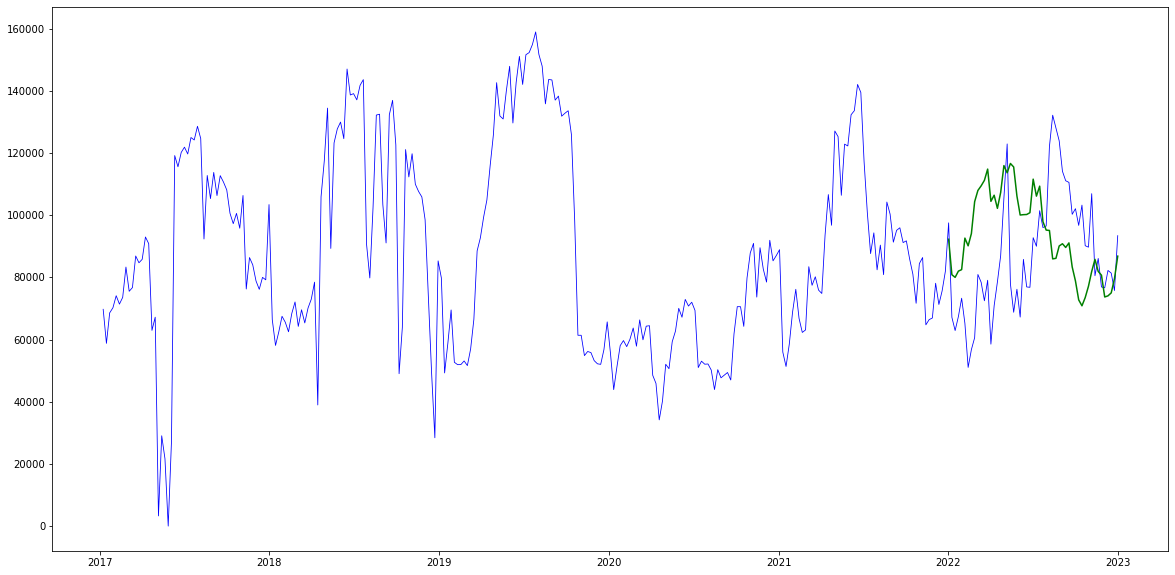

In [35]:
mod_ = ARIMA(endog=tf_train, order=(48,0,9)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tf_week, c='blue', linewidth=0.8)
plt.plot(tf_test.index, forecast, c='green')
plt.show()

In [36]:
skMAPE(tf_test,forecast), error_sum(tf_test, forecast)

(0.2687918229802696, '6.66%')

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


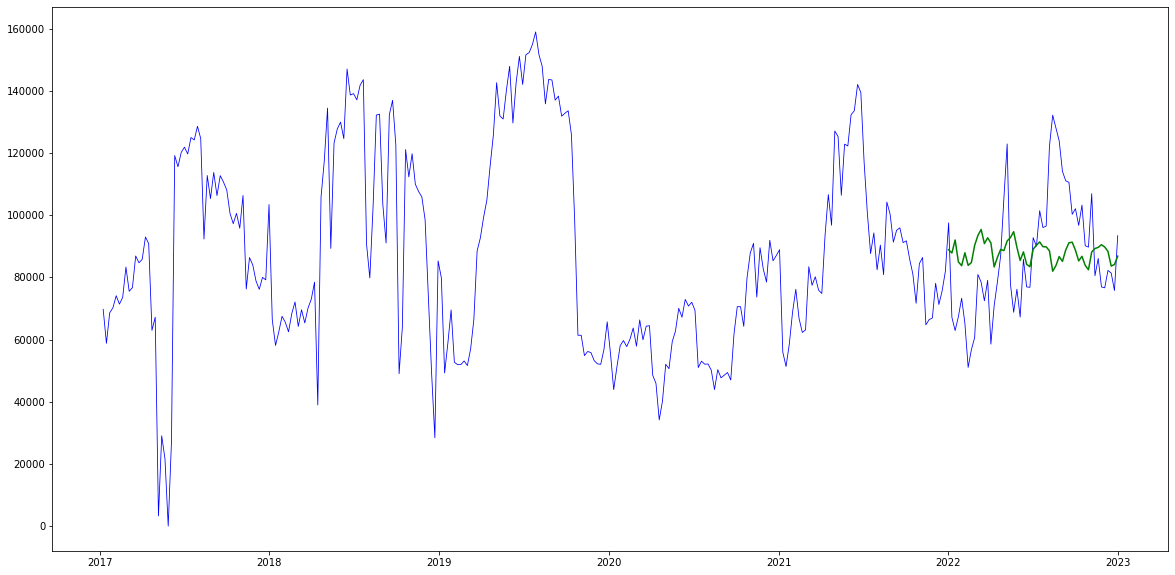

In [40]:
mod_ = ARIMA(endog=tf_train, order=(12,0,9)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tf_week, c='blue', linewidth=0.8)
plt.plot(tf_test.index, forecast, c='green')
plt.show()

In [41]:
skMAPE(tf_test,forecast), error_sum(tf_test, forecast)

(0.19513198279036698, '0.942%')

# Total finished

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


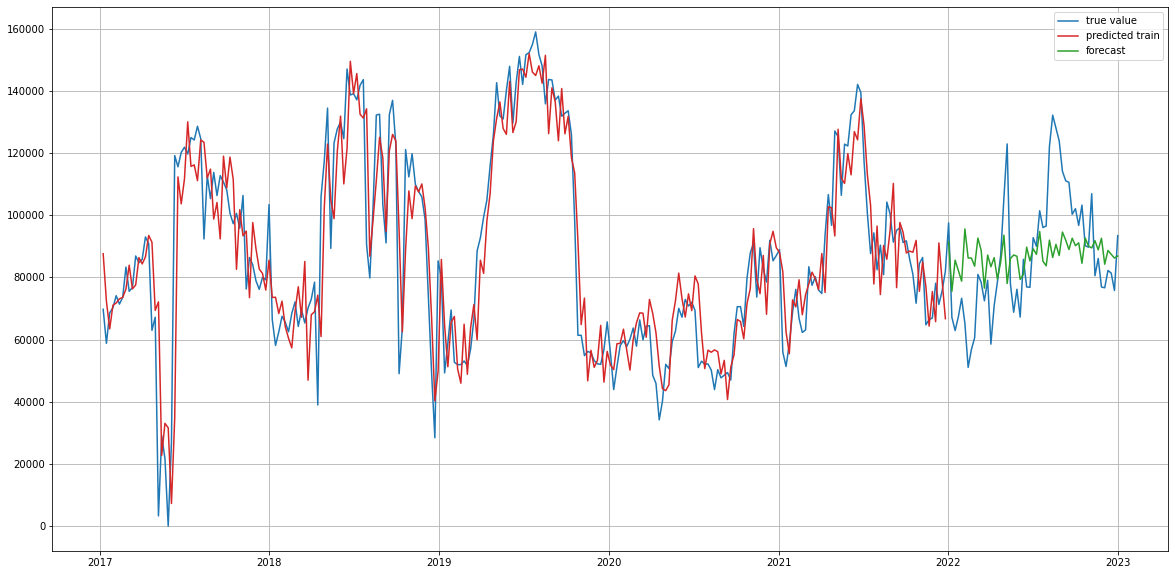

In [46]:
mod_ = ARIMA(endog=tf_train, order=(12,0,25)).fit()
forecast = mod_.forecast(53)
predicted = mod_.predict(-260)

plt.figure(figsize=(20,10))
plt.plot(tf_week, c='tab:blue', label='true value')
plt.plot(tf_train.index, predicted, c='tab:red', label='predicted train')
plt.plot(tf_test.index, forecast, c='tab:green', label='forecast')
plt.legend()
plt.grid()
plt.show()

In [47]:
skMAPE(tf_test,forecast), error_sum(tf_test, forecast)

(0.17114276495942088, '0.139%')

In [48]:
order_tf=(12,0,25)
model_for_tf = ARIMA(endog=tf_week, order=order_tf).fit()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


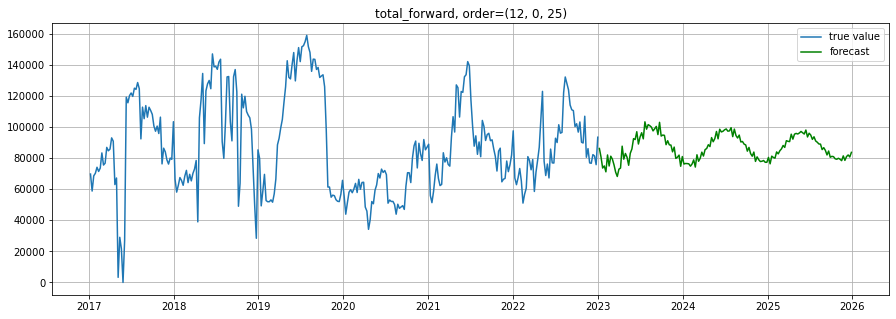

In [56]:
forecast_tf = model_for_tf.forecast(52*3)

plt.figure(figsize=(15,5))
plt.plot(tf_week, c='tab:blue', label='true value')
plt.plot(forecast_tf, c='green', label='forecast')
plt.title(f'total_forward, order={order_tf}')
plt.legend()
plt.grid()
plt.show()

In [51]:
forecast_tf_2023 = forecast_tf.iloc[:52].sum()
forecast_tf_2024 = forecast_tf.iloc[52:104].sum()
forecast_tf_2025 = forecast_tf.iloc[104:].sum()

In [53]:
forecasts_tf = [forecast_tf_2023,forecast_tf_2024,forecast_tf_2025]
years = [2023,2024,2025]
for i in range(3):
    print(f'sum of cars in {years[i]}: {forecasts_tf[i]}')

sum of cars in 2023: 4501840.895477191
sum of cars in 2024: 4491660.53781344
sum of cars in 2025: 4520913.154813058


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


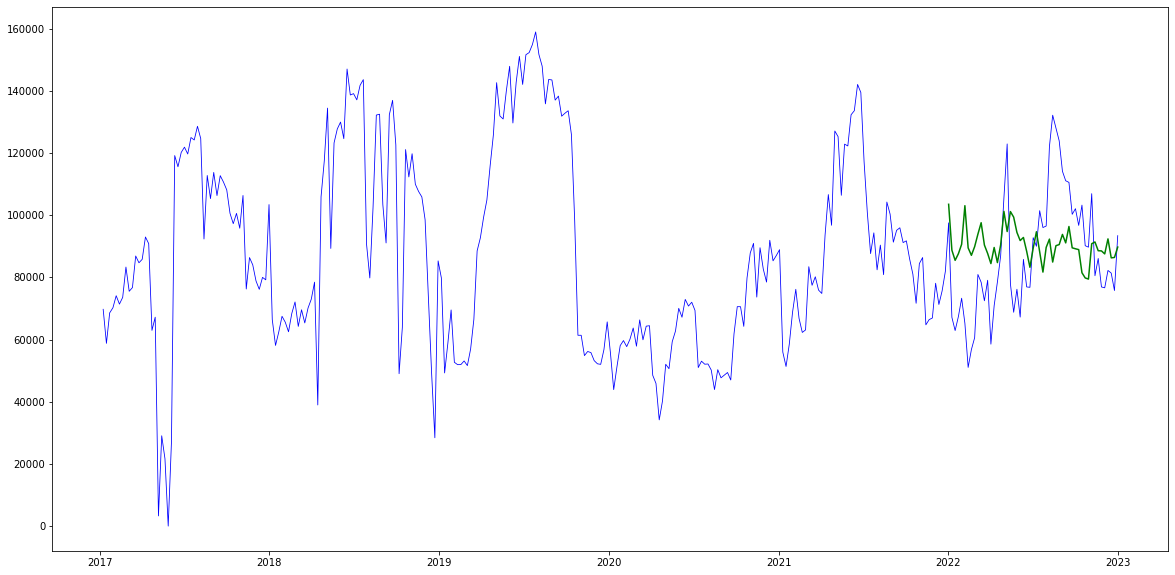

In [44]:
mod_ = ARIMA(endog=tf_train, order=(35,0,25)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tf_week, c='blue', linewidth=0.8)
plt.plot(tf_test.index, forecast, c='green')
plt.show()

In [45]:
skMAPE(tf_test,forecast), error_sum(tf_test, forecast)

(0.20692525265569836, '3.299%')

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


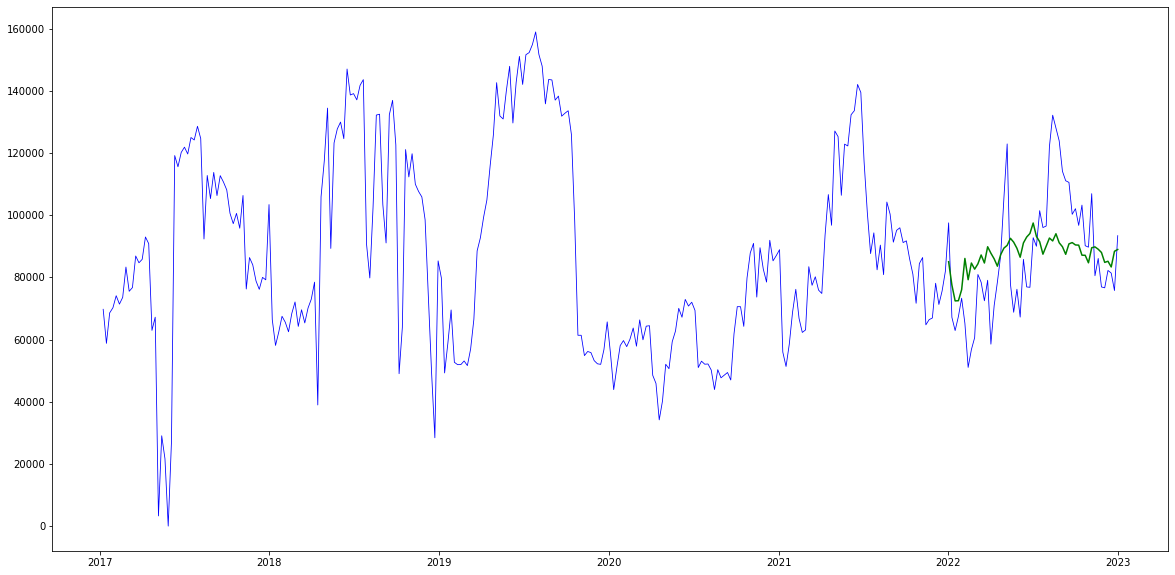

In [34]:
mod_ = ARIMA(endog=tf_train, order=(30,0,11)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tf_week, c='blue', linewidth=0.8)
plt.plot(tf_test.index, forecast, c='green')
plt.show()

In [35]:
skMAPE(tf_test,forecast), error_sum(tf_test, forecast)

(0.1656254862092878, '0.279%')

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


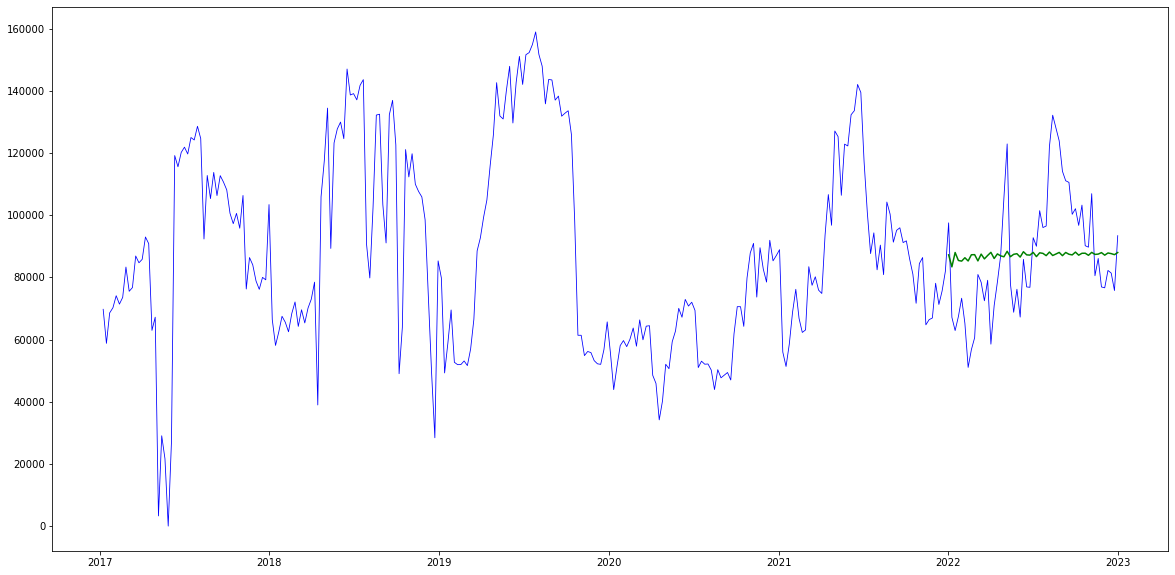

In [45]:
mod_ = ARIMA(endog=tf_train, order=(10,0,5)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tf_week, c='blue', linewidth=0.8)
plt.plot(tf_test.index, forecast, c='green')
plt.show()

In [46]:
skMAPE(tf_test,forecast), error_sum(tf_test, forecast)

(0.18472051102316267, '0.141%')

In [32]:
#tf_decomposed = seasonal_decompose(tf_train, model='additive', extrapolate_trend='freq')

#fig = plt.figure(figsize=(13,9))
#ax1 = fig.add_subplot(411)
#ax1.set_title('count')
#plt.plot(tf_decomposed.observed)

#ax2 = fig.add_subplot(412)
#ax2.set_ylabel('trend')
#plt.plot(tf_decomposed.trend)

#ax3 = fig.add_subplot(413)
#ax3.set_ylabel('seasonal')
#plt.plot(tf_decomposed.seasonal)

#ax4 = fig.add_subplot(414)
#ax4.set_ylabel('resid')
#plt.plot(tf_decomposed.resid)

#plt.show()

In [33]:
#result = seasonal_decompose(tf_train, model='additive',extrapolate_trend='freq')
#result.plot()
#plt.show()

In [34]:
#from statsmodels.tsa.seasonal import seasonal_decompose

In [47]:
def plot_decomposition(ts_decomposed):
    fig = plt.figure(figsize=(13,9))
    ax1 = fig.add_subplot(411)
    ax1.set_title('count')
    plt.plot(ts_decomposed.observed)

    ax2 = fig.add_subplot(412)
    ax2.set_ylabel('trend')
    plt.plot(ts_decomposed.trend)

    ax3 = fig.add_subplot(413)
    ax3.set_ylabel('seasonal')
    plt.plot(ts_decomposed.seasonal)

    ax4 = fig.add_subplot(414)
    ax4.set_ylabel('resid')
    plt.plot(ts_decomposed.resid)

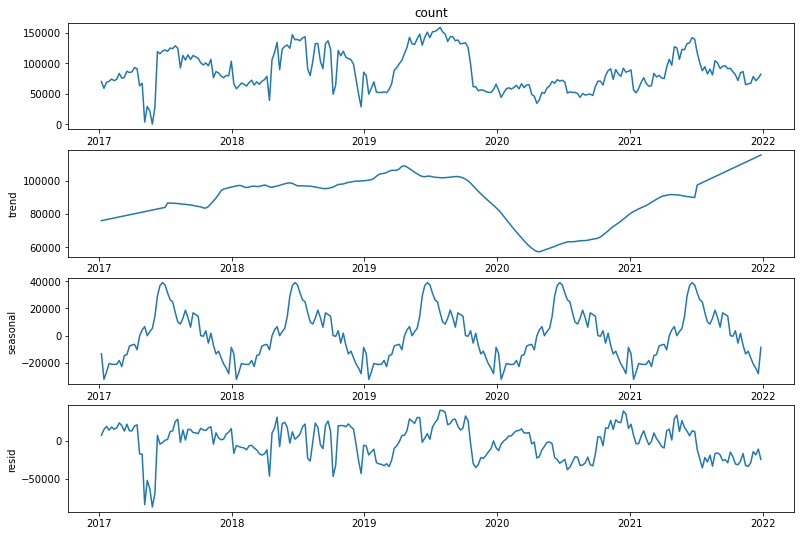

In [48]:
tf_decomposed = seasonal_decompose(tf_train, model='additive', extrapolate_trend='freq')
plot_decomposition(tf_decomposed)

In [49]:
tf_seasonal = tf_decomposed.seasonal
tf_seasonal.head()

date
2017-01-08   -13396.087368
2017-01-15   -32311.472427
2017-01-22   -26974.561333
2017-01-29   -20625.875239
2017-02-05   -21144.679529
Freq: W-SUN, Name: seasonal, dtype: float64

In [50]:
check_stationarity(tf_seasonal) # D = 0

adf:  -6.373307400026606
p-value:  2.316357419035761e-08
Critical values:  {'1%': -3.457437824930831, '5%': -2.873459364726563, '10%': -2.573122099570008}
The series is stationary


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


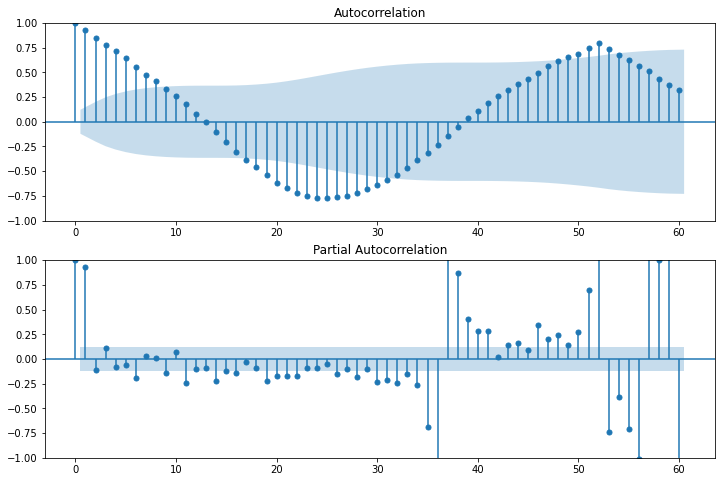

In [51]:
plot_acf_pacf(tf_seasonal) # Q = 9,32; P = 1,2,6,11,35

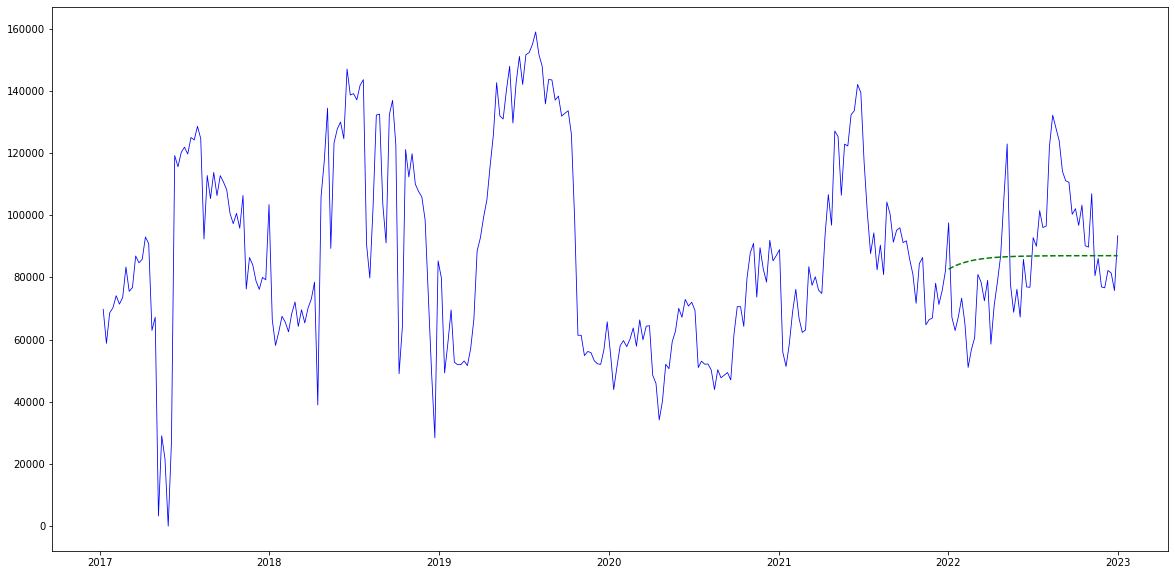

In [77]:
model = pm.auto_arima(tf_train, seasonal=True, m=52)
forecasts = model.predict(tf_test.shape[0])

#x = np.arange(y.shape[0])
plt.figure(figsize=(20,10))
plt.plot(tf_week, c='blue', linewidth=0.8)
plt.plot(tf_week.iloc[260:].index, forecasts, c='green', ls='--')
plt.show()

In [79]:
skMAPE(tf_test,forecasts), error_sum(tf_test, forecasts)

(0.18183392258891784, '1.081%')

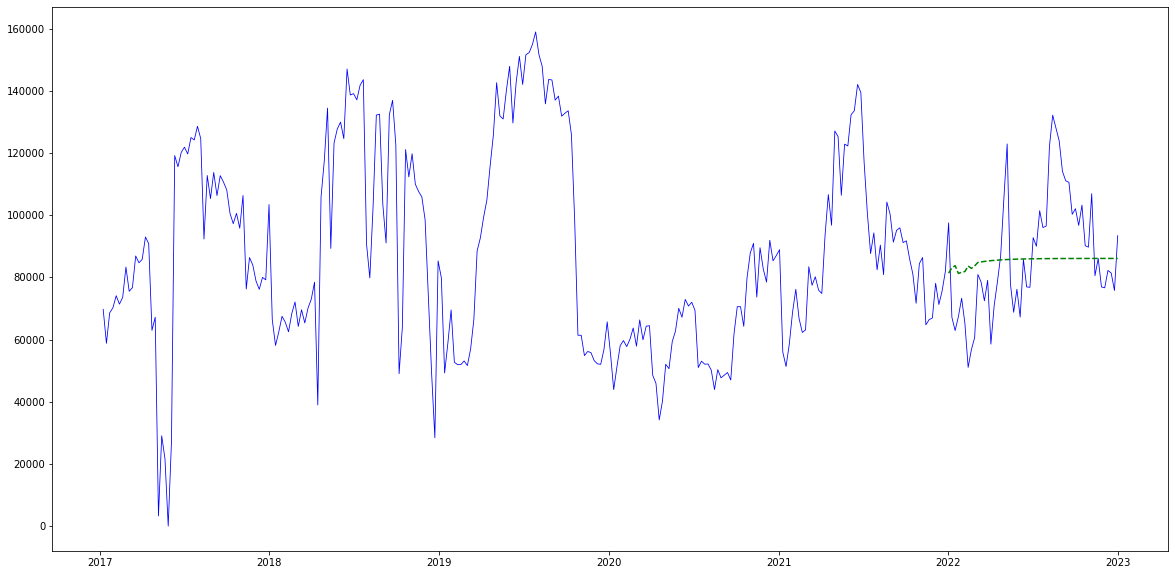

In [80]:
model = pm.auto_arima(tf_train, seasonal=True, m=10)
forecasts = model.predict(tf_test.shape[0])

#x = np.arange(y.shape[0])
plt.figure(figsize=(20,10))
plt.plot(tf_week, c='blue', linewidth=0.8)
plt.plot(tf_week.iloc[260:].index, forecasts, c='green', ls='--')
plt.show()

In [82]:
skMAPE(tf_test,forecasts), error_sum(tf_test, forecasts)

(0.1767001114669175, '2.32%')

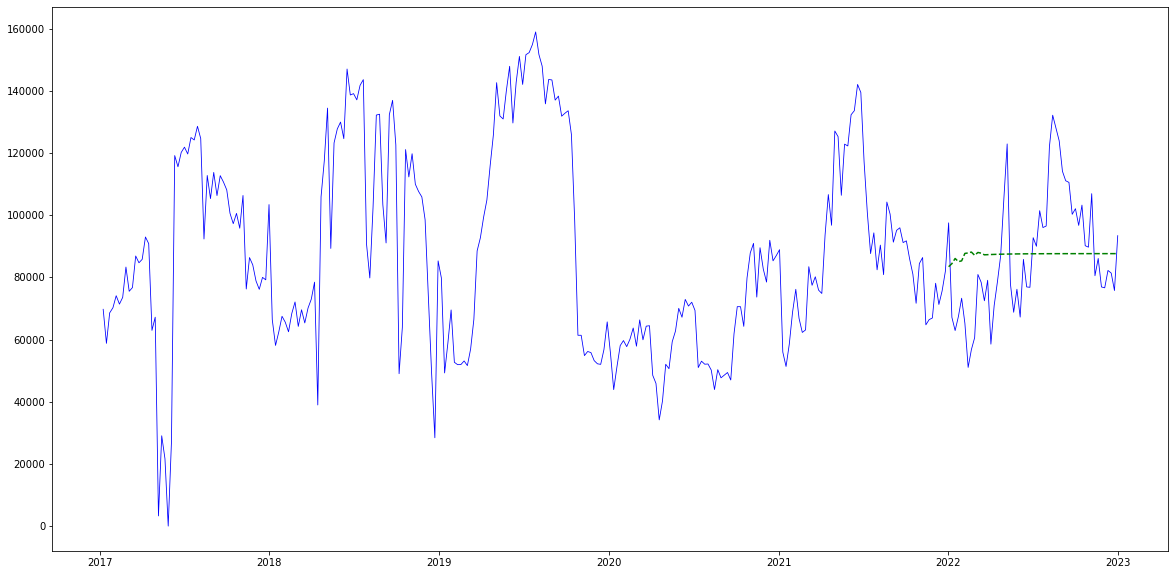

In [88]:
model = pm.auto_arima(tf_train, seasonal=True, m=12)
forecasts = model.predict(tf_test.shape[0])

#x = np.arange(y.shape[0])
plt.figure(figsize=(20,10))
plt.plot(tf_week, c='blue', linewidth=0.8)
plt.plot(tf_week.iloc[260:].index, forecasts, c='green', ls='--')
plt.show()

In [91]:
predicted_sum = forecasts.sum()
test_sum = tf_test.sum()
skMAPE(tf_test, forecasts), abs(1-predicted_sum/test_sum)

(0.18848481187621965, 0.0004577241058738579)

# Visualization of total_reverse

In [126]:
total_reverse_for_period = pd.DataFrame({'date': dates, 'count': df_nonan['reverse']})
total_reverse_for_period.head()

,date,count
2,2017-01-01,39
3,2017-01-01,51
4,2017-01-01,46
5,2017-01-01,46
6,2017-01-01,53


In [127]:
sum_reverse_within_day = total_reverse_for_period.groupby('date').agg({'count': 'sum'})
sum_reverse_within_day.head()

,count
date,
2017-01-01,3802
2017-01-02,10495
2017-01-03,13990
2017-01-04,14345
2017-01-05,15089


In [128]:
tr_week = sum_reverse_within_day.resample('W', closed='left').sum()['count']
tr_week.head()

date
2017-01-08    86891
2017-01-15    76365
2017-01-22    72963
2017-01-29    72276
2017-02-05    74991
Freq: W-SUN, Name: count, dtype: int64

In [129]:
pd.DataFrame(tr_week).head()

,count
date,
2017-01-08,86891
2017-01-15,76365
2017-01-22,72963
2017-01-29,72276
2017-02-05,74991


In [130]:
tr_train, tr_test = train_test_split(tr_week, test_size=53)
tr_train.tail(), tr_test.head()

(date
 2021-11-28    93045
 2021-12-05    91509
 2021-12-12    88406
 2021-12-19    90319
 2021-12-26    89819
 Freq: W-SUN, Name: count, dtype: int64,
 date
 2022-01-02     71860
 2022-01-09    103239
 2022-01-16     77490
 2022-01-23     76276
 2022-01-30     77030
 Freq: W-SUN, Name: count, dtype: int64)

In [131]:
pd.DataFrame(tr_train).head()

,count
date,
2017-01-08,86891
2017-01-15,76365
2017-01-22,72963
2017-01-29,72276
2017-02-05,74991


In [132]:
pd.DataFrame(tr_test).head()

,count
date,
2022-01-02,71860
2022-01-09,103239
2022-01-16,77490
2022-01-23,76276
2022-01-30,77030


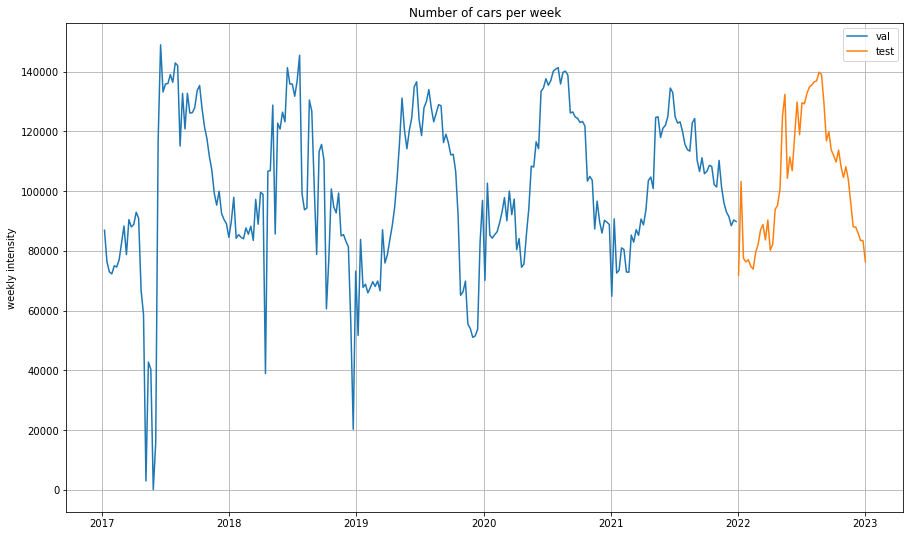

In [133]:
plt.figure(figsize=(15,9))
plt.grid()
plt.title('Number of cars per week')
plt.ylabel('weekly intensity')
plt.plot(tr_train, label='val')
plt.plot(tr_test, label='test')
plt.legend();

In [213]:
check_stationarity(tr_train) # d=0

adf:  -4.229069583955246
p-value:  0.0005880932439054457
Critical values:  {'1%': -3.456360306409983, '5%': -2.8729872043802356, '10%': -2.572870232500465}
The series is stationary


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


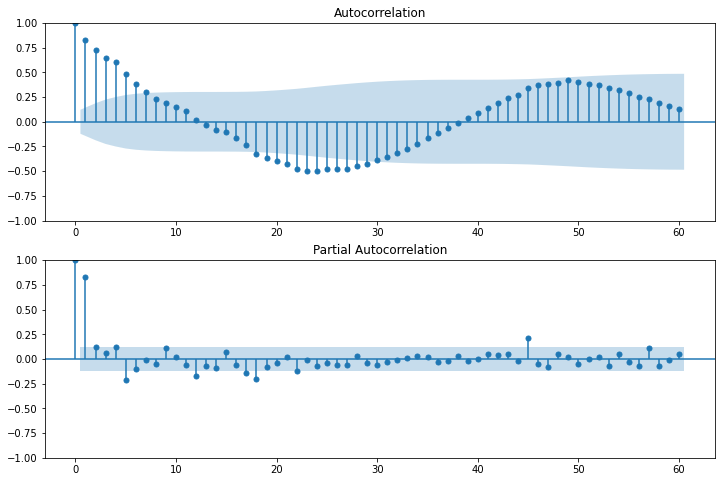

In [214]:
plot_acf_pacf(tr_train)

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


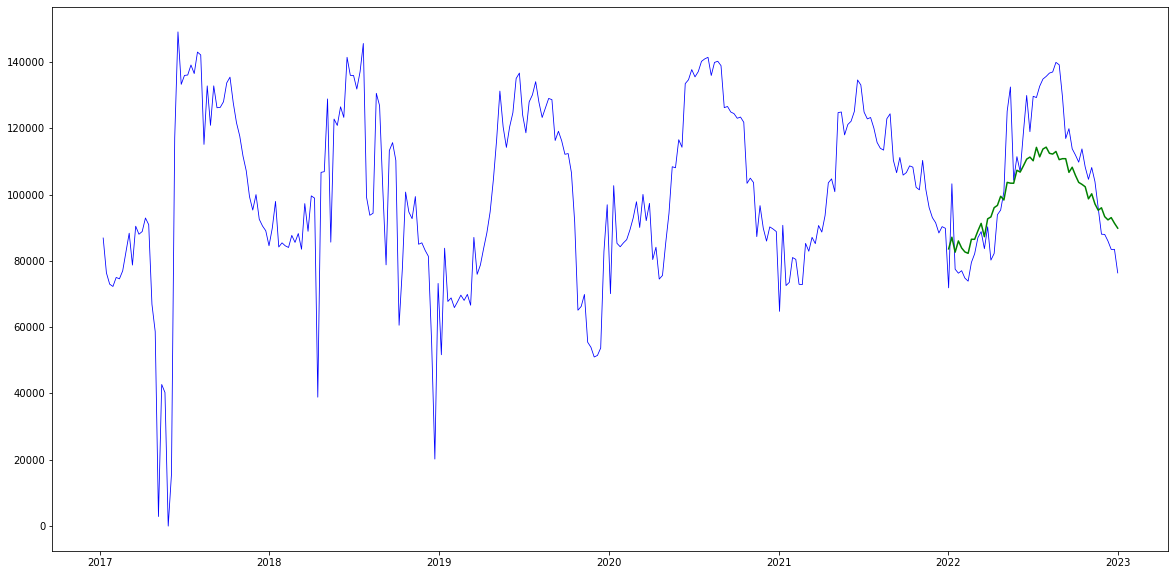

In [97]:
mod_ = ARIMA(endog=tr_train, order=(30,0,11)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={45,0,30}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

In [98]:
skMAPE(tr_test,forecast), error_sum(tr_test, forecast)

(0.09757466363366898, '4.768%')

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


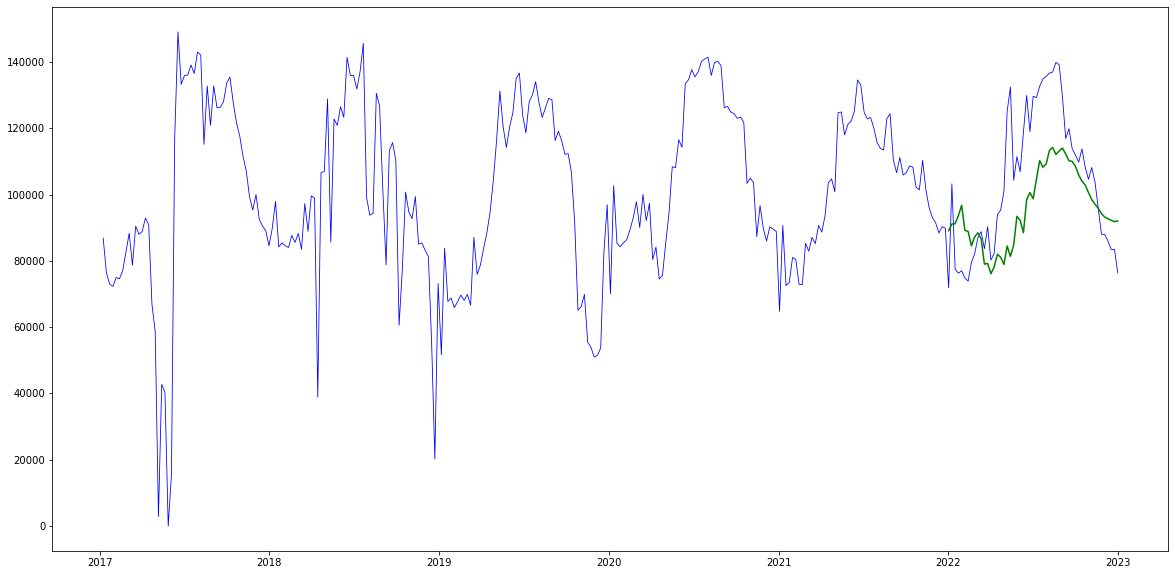

In [99]:
mod_ = ARIMA(endog=tr_train, order=(5,0,30)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='blue', linewidth=0.8)
plt.plot(tr_test.index, forecast, c='green')
plt.show()

In [100]:
skMAPE(tr_test,forecast), error_sum(tr_test, forecast)

(0.13584214630494532, '9.039%')

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


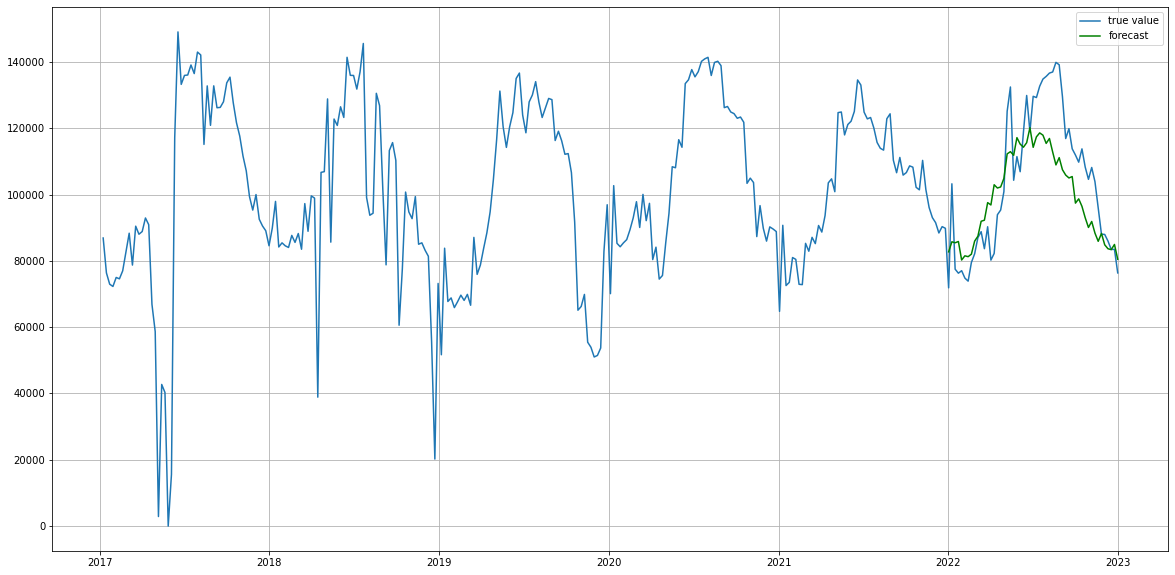

In [123]:
mod_ = ARIMA(endog=tr_train, order=(15,0,30)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.legend()
plt.grid()
plt.show()

In [124]:
skMAPE(tr_test,forecast), error_sum(tr_test, forecast)

(0.10093352472301217, '5.135%')

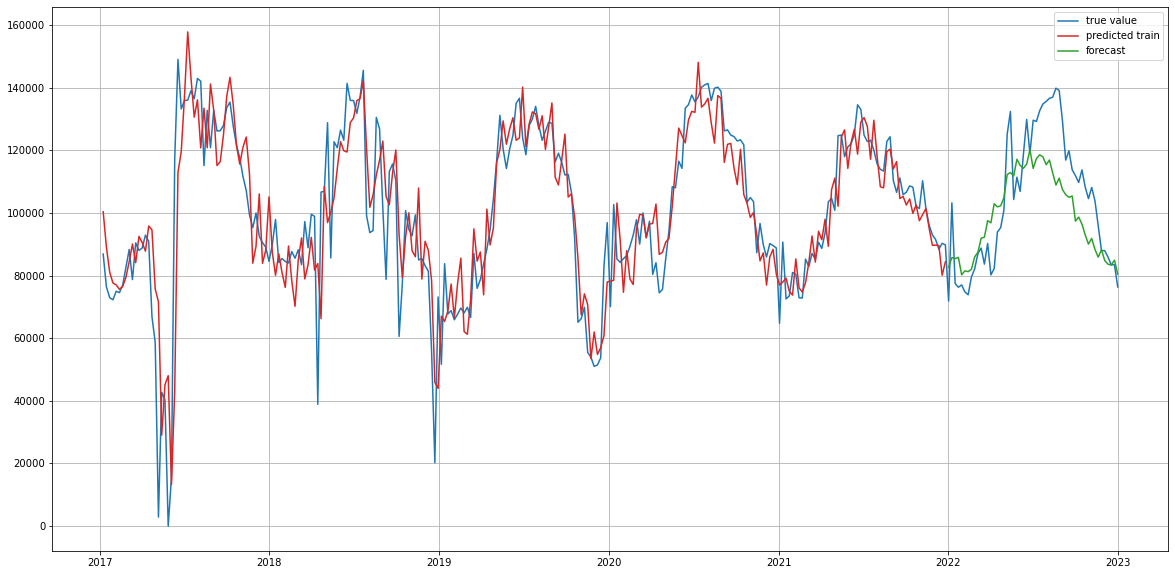

In [133]:
predicted = mod_.predict(-260)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_train.index, predicted, c='tab:red', label='predicted train')
plt.plot(tr_test.index, forecast, c='tab:green', label='forecast')
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


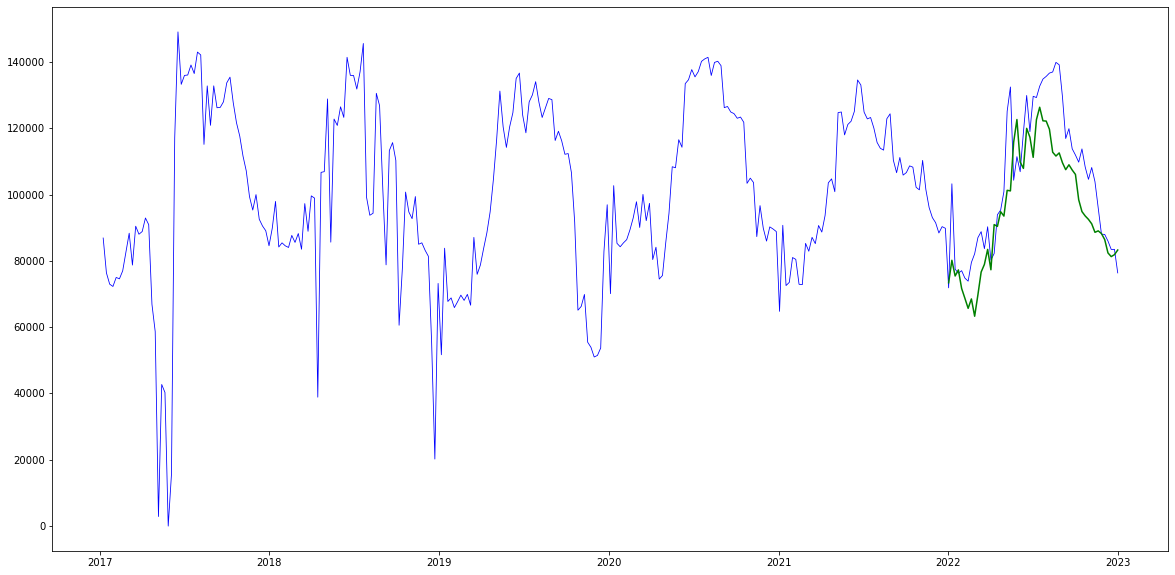

In [103]:
mod_ = ARIMA(endog=tr_train, order=(12,0,40)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='blue', linewidth=0.8)
plt.plot(tr_test.index, forecast, c='green')
plt.show()

In [104]:
skMAPE(tr_test,forecast), error_sum(tr_test, forecast)

(0.09703659254623165, '9.405%')

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


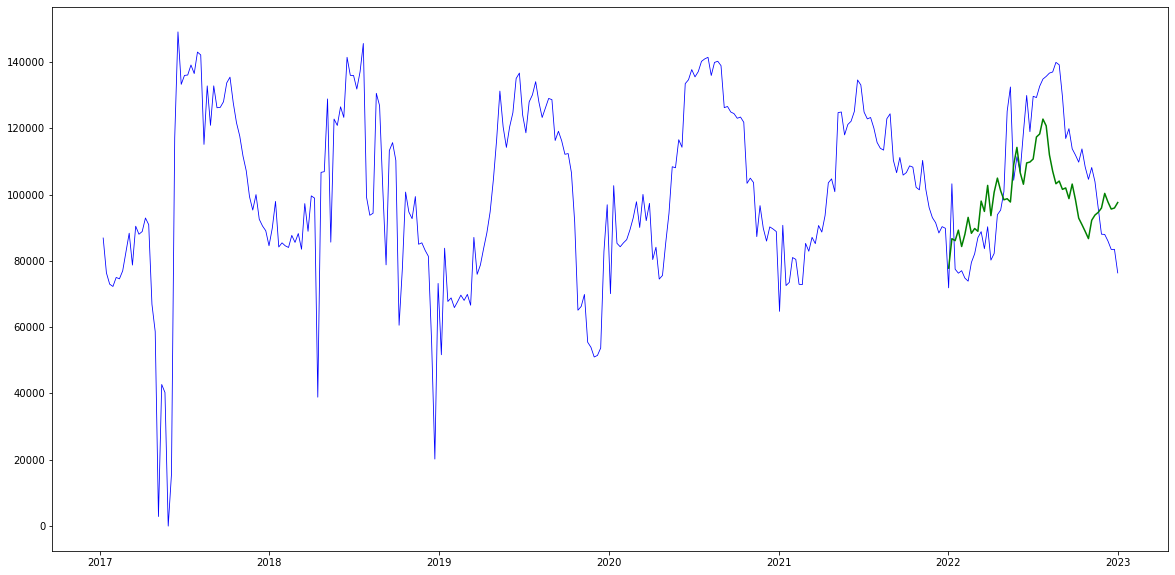

In [105]:
mod_ = ARIMA(endog=tr_train, order=(12,0,50)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='blue', linewidth=0.8)
plt.plot(tr_test.index, forecast, c='green')
plt.show()

In [106]:
skMAPE(tr_test,forecast), error_sum(tr_test, forecast)

(0.13695376911574697, '5.015%')

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


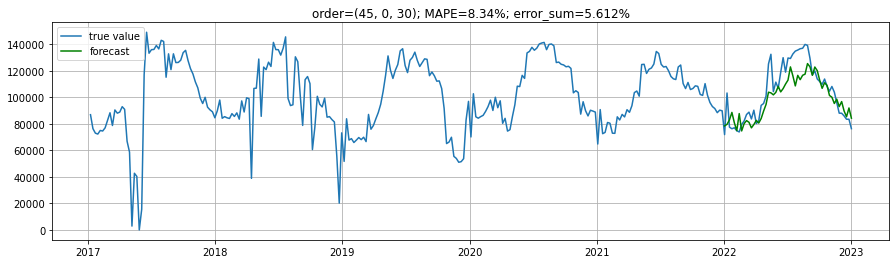

In [224]:
mod_ = ARIMA(endog=tr_train, order=(45,0,30)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(15,4))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={45,0,30}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

In [226]:
skMAPE(tr_test,forecast), error_sum(tr_test, forecast)

(0.08344404184248336, '5.612%')

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


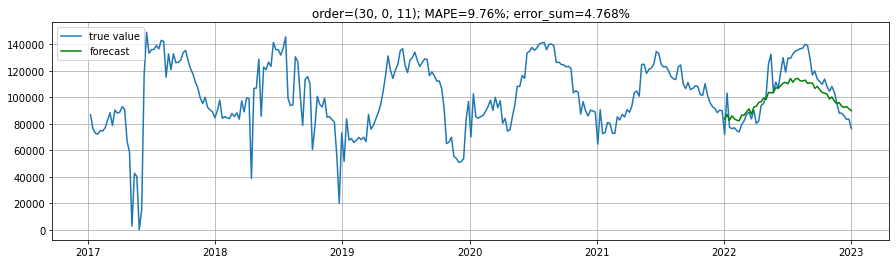

In [228]:
mod_ = ARIMA(endog=tr_train, order=(30,0,11)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(15,4))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={30,0,11}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


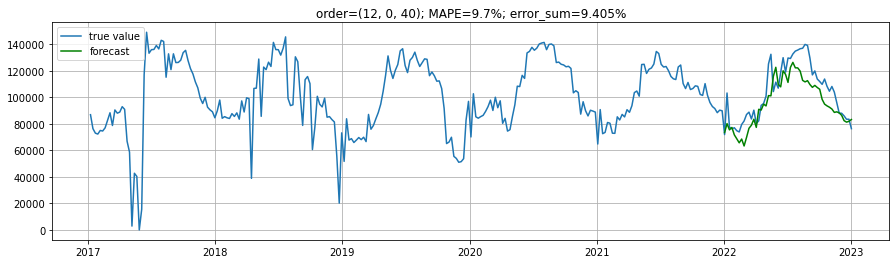

In [230]:
mod_ = ARIMA(endog=tr_train, order=(12,0,40)).fit()
forecast = mod_.forecast(53)

plt.figure(figsize=(15,4))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={12,0,40}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


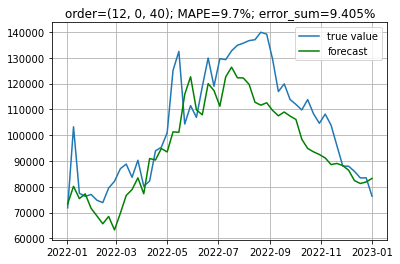

In [231]:
mod_ = ARIMA(endog=tr_train, order=(12,0,40)).fit()
forecast = mod_.forecast(53)

#plt.figure(figsize=(15,4))
plt.plot(tr_test, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={12,0,40}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


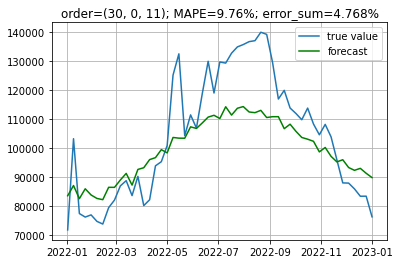

In [233]:
order=(30,0,11)
mod_ = ARIMA(endog=tr_train, order=order).fit()
forecast = mod_.forecast(53)

#plt.figure(figsize=(15,4))
plt.plot(tr_test, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={order}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


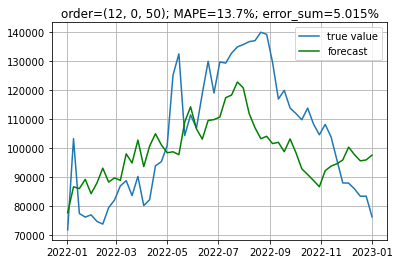

In [234]:
order=(12,0,50)
mod_ = ARIMA(endog=tr_train, order=order).fit()
forecast = mod_.forecast(53)

#plt.figure(figsize=(15,4))
plt.plot(tr_test, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={order}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


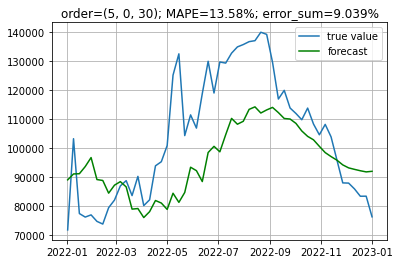

In [235]:
order=(5,0,30)
mod_ = ARIMA(endog=tr_train, order=order).fit()
forecast = mod_.forecast(53)

#plt.figure(figsize=(15,4))
plt.plot(tr_test, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={order}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


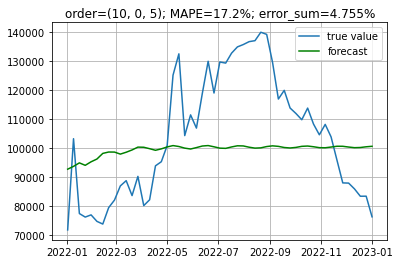

In [236]:
order=(10,0,5)
mod_ = ARIMA(endog=tr_train, order=order).fit()
forecast = mod_.forecast(53)

#plt.figure(figsize=(15,4))
plt.plot(tr_test, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={order}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


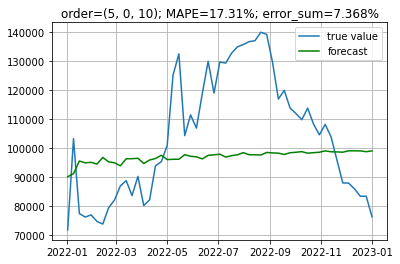

In [237]:
order=(5,0,10)
mod_ = ARIMA(endog=tr_train, order=order).fit()
forecast = mod_.forecast(53)

#plt.figure(figsize=(15,4))
plt.plot(tr_test, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={order}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


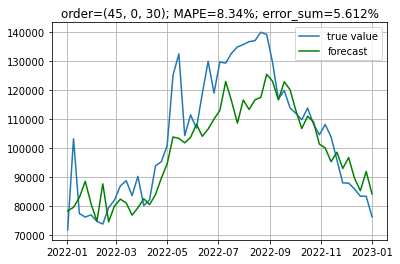

In [238]:
order=(45,0,30)
mod_ = ARIMA(endog=tr_train, order=order).fit()
forecast = mod_.forecast(53)

#plt.figure(figsize=(15,4))
plt.plot(tr_test, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.title(f'order={order}; MAPE={round(skMAPE(tr_test,forecast)*100,2)}%; error_sum={error_sum(tr_test, forecast)}')
plt.legend()
plt.grid()
plt.show()

In [239]:
tr_week

date
2017-01-08    86891
2017-01-15    76365
2017-01-22    72963
2017-01-29    72276
2017-02-05    74991
              ...  
2022-12-04    87970
2022-12-11    85973
2022-12-18    83445
2022-12-25    83465
2023-01-01    76365
Freq: W-SUN, Name: count, Length: 313, dtype: int64

In [134]:
order1=(45,0,30)
model_for_tr1 = ARIMA(endog=tr_week, order=order1).fit()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


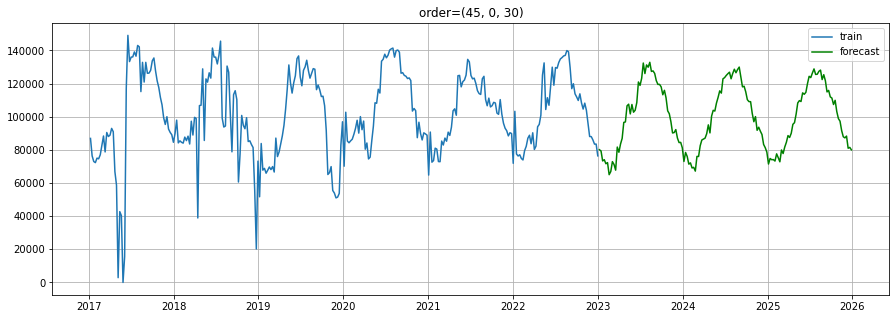

In [135]:
forecast1 = model_for_tr1.forecast(52*3)

plt.figure(figsize=(15,5))
plt.plot(tr_week, c='tab:blue', label='train')
plt.plot(forecast1, c='green', label='forecast')
plt.title(f'order={order1}')
plt.legend()
plt.grid()
plt.show()

In [136]:
forecast1_2023 = forecast1.iloc[:52].sum()
forecast1_2024 = forecast1.iloc[52:104].sum()
forecast1_2025 = forecast1.iloc[104:].sum()

In [137]:
forecasts1 = [forecast1_2023,forecast1_2024,forecast1_2025]
years = [2023,2024,2025]
for i in range(3):
    print(f'sum of cars in {years[i]}: {forecasts1[i]}')

sum of cars in 2023: 5183712.1178531125
sum of cars in 2024: 5200763.732675581
sum of cars in 2025: 5212780.484326577


In [281]:
order2=(45,0,29)
model_for_tr2 = ARIMA(endog=tr_week, order=order2).fit()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


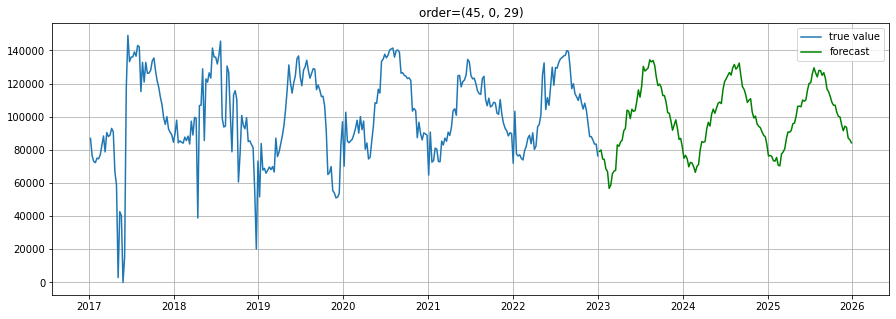

In [282]:
forecast2 = model_for_tr2.forecast(52*3)

plt.figure(figsize=(15,5))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(forecast2, c='green', label='forecast')
plt.title(f'order={order2}')
plt.legend()
plt.grid()
plt.show()

In [283]:
forecast2_2023 = forecast2.iloc[:52].sum()
forecast2_2024 = forecast2.iloc[52:104].sum()
forecast2_2025 = forecast2.iloc[104:].sum()

In [284]:
forecasts2 = [forecast2_2023,forecast2_2024,forecast2_2025]
years = [2023,2024,2025]
for i in range(3):
    print(f'sum of cars in {years[i]}: {forecasts2[i]}')

sum of cars in 2023: 5148935.079493839
sum of cars in 2024: 5200353.444044279
sum of cars in 2025: 5222449.432315905


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


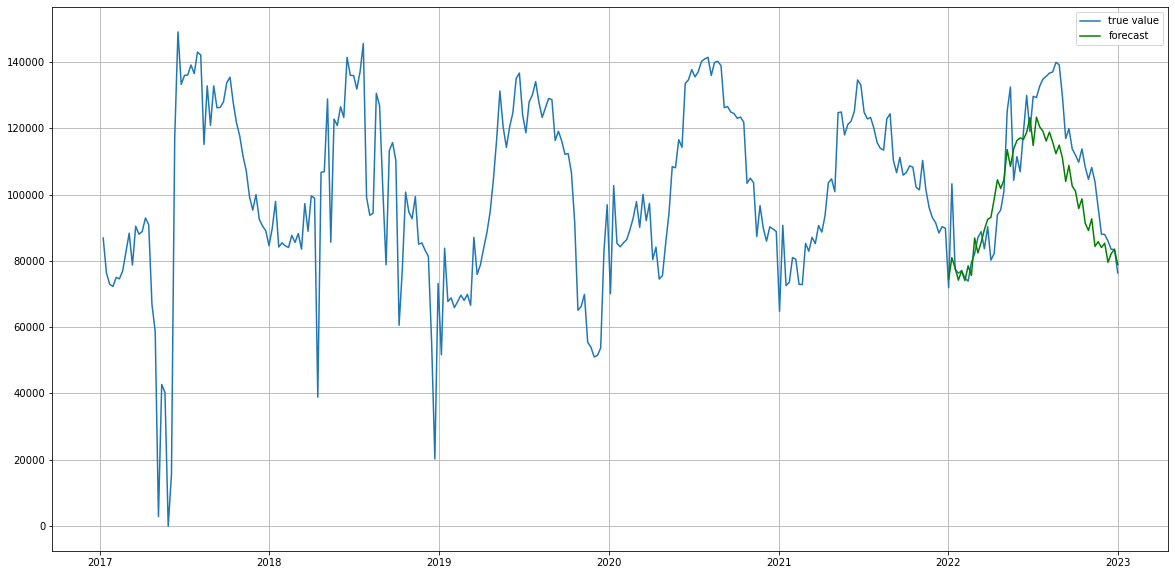

In [201]:
mod_ = ARIMA(endog=tr_train, order=(20,0,30)).fit() # показать первой
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.legend()
plt.grid()
plt.show()

In [202]:
skMAPE(tr_test,forecast), error_sum(tr_test, forecast)

(0.09008908439302438, '6.329%')

In [219]:
tr_test.shape[0]

53

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


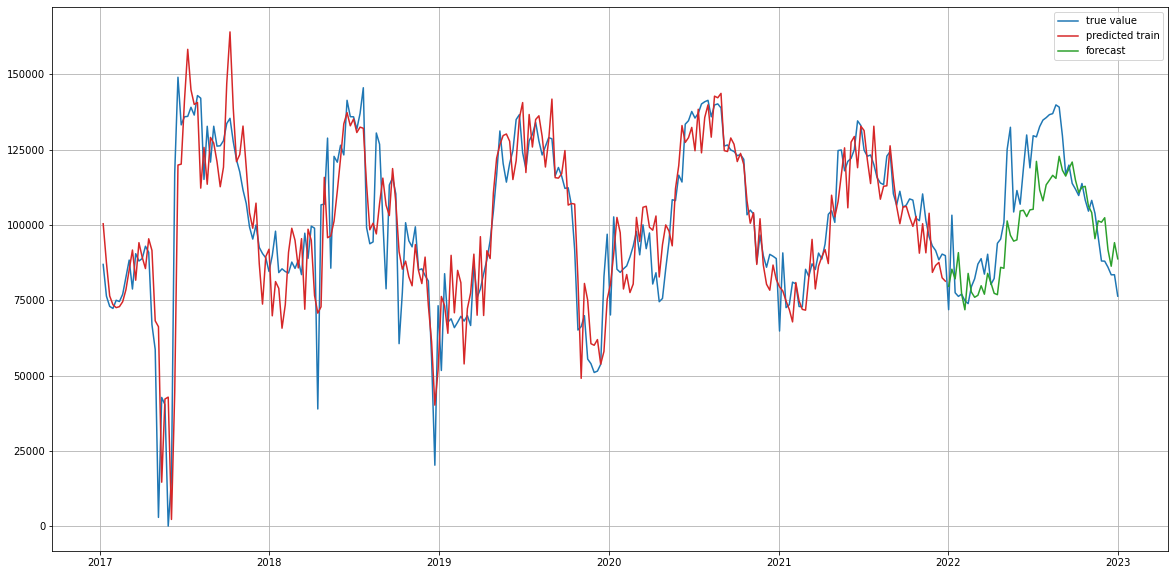

In [220]:
model = ARIMA(endog=tr_train, order=(45,0,29)).fit() 
forecast = model.forecast(tr_test.shape[0])
predicted = model.predict(-260)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_train.index, predicted, c='tab:red', label='predicted train')
plt.plot(tr_test.index, forecast, c='tab:green', label='forecast')
plt.legend()
plt.grid()
plt.show()

In [218]:
skMAPE(tr_test,forecast), error_sum(tr_test, forecast)

(0.10114276230815566, '6.647%')

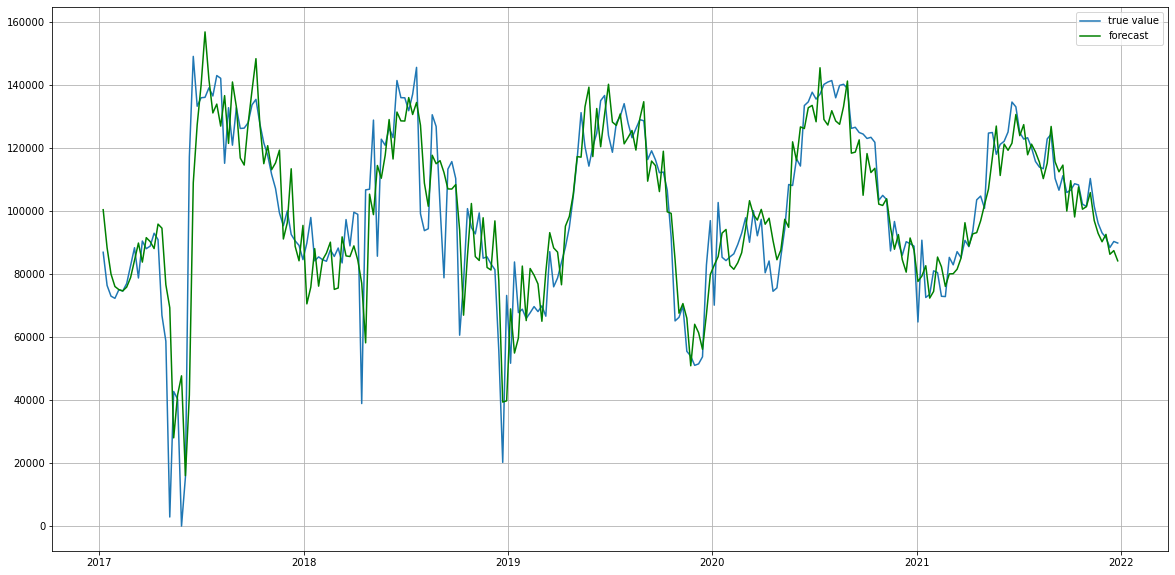

In [122]:
predict_all = mod_.predict(-260)
plt.figure(figsize=(20,10))
plt.plot(tr_week.iloc[:260], c='tab:blue', label='true value')
plt.plot(tr_week.iloc[:260].index, predict_all, c='green', label='forecast')
plt.legend()
plt.grid()
plt.show()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


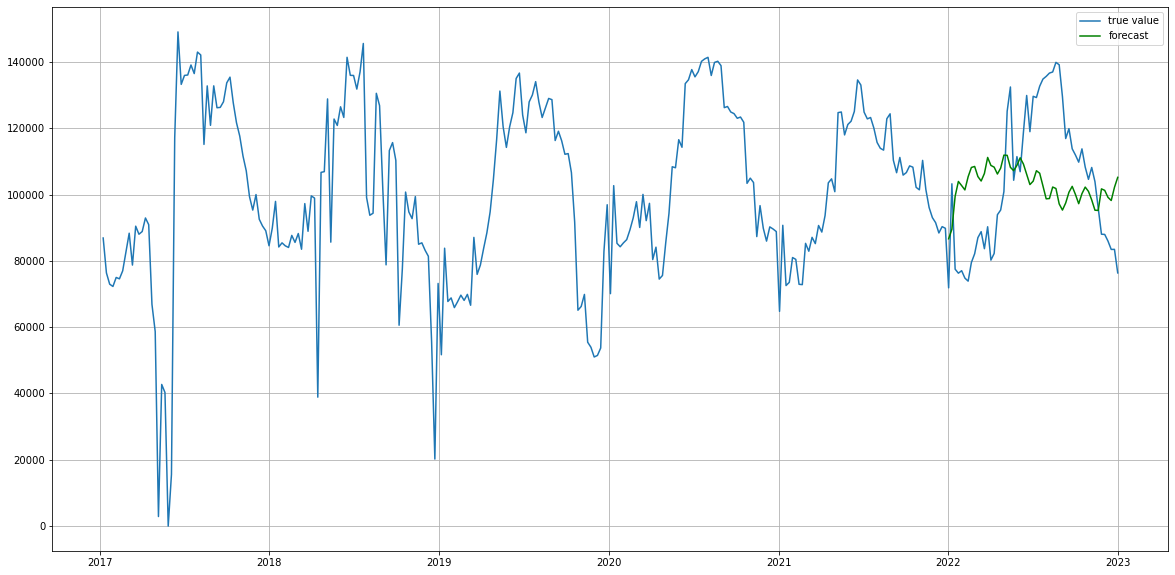

In [199]:
mod_ = SARIMAX(endog=tr_train, order=(5,0,10), seasonal_order=(2,0,2,48)).fit() # показать первой
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.legend()
plt.grid()
plt.show()

In [ ]:
mod_ = SARIMAX(endog=tr_train, order=(5,0,10), seasonal_order=(2,0,2,48)).fit() # показать первой
forecast = mod_.forecast(53)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.legend()
plt.grid()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[48] intercept   : AIC=inf, Time=7.01 sec
 ARIMA(0,0,0)(0,0,0)[48] intercept   : AIC=6036.720, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[48] intercept   : AIC=5741.259, Time=0.94 sec
 ARIMA(0,0,1)(0,0,1)[48] intercept   : AIC=5911.414, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[48]             : AIC=6746.056, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[48] intercept   : AIC=5739.357, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[48] intercept   : AIC=5741.261, Time=0.73 sec
 ARIMA(1,0,0)(1,0,1)[48] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(2,0,0)(0,0,0)[48] intercept   : AIC=5737.443, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[48] intercept   : AIC=5739.371, Time=1.16 sec
 ARIMA(2,0,0)(0,0,1)[48] intercept   : AIC=5739.378, Time=0.97 sec
 ARIMA(2,0,0)(1,0,1)[48] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(3,0,0)(0,0,0)[48] intercept   : AIC=5738.614, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[48] intercept   : AIC=5739.163, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[48] intercept

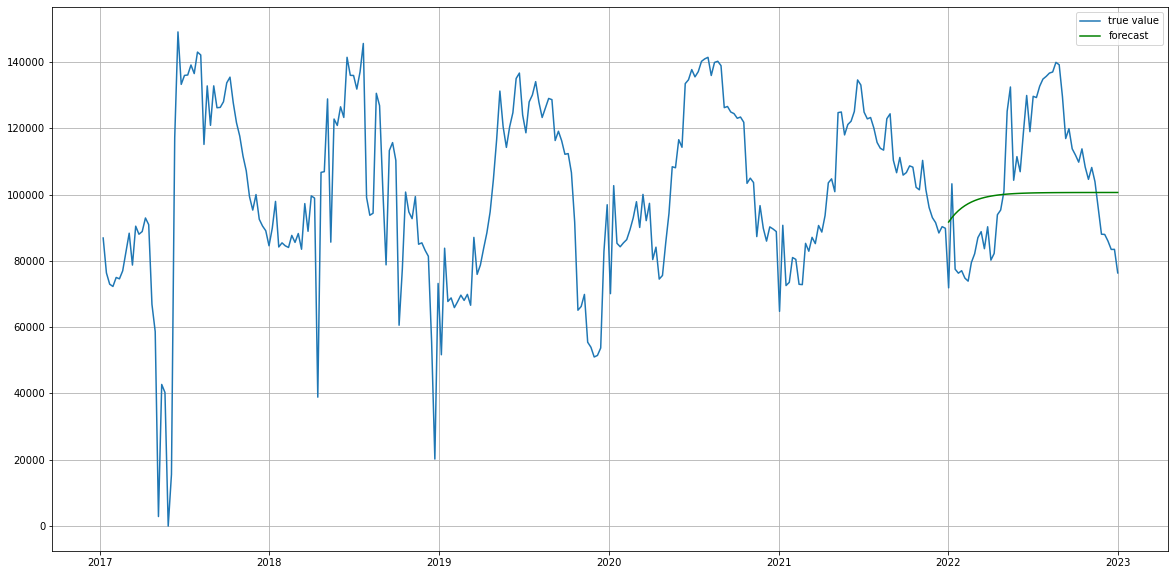

In [200]:
model = pm.auto_arima(tr_train, seasonal=True, m=48, trace=True)
forecast = model.predict(53)

plt.figure(figsize=(20,10))
plt.plot(tr_week, c='tab:blue', label='true value')
plt.plot(tr_test.index, forecast, c='green', label='forecast')
plt.legend()
plt.grid()
plt.show()

# Visualization of car_forward

In [129]:
car_forward_for_period = pd.DataFrame({'date': dates, 'count': df_nonan['car_forward']})
car_forward_for_period.head()

,date,count
2,2017-01-01,35
3,2017-01-01,64
4,2017-01-01,121
5,2017-01-01,113
6,2017-01-01,73


In [130]:
sum_car_forward_within_day = car_forward_for_period.groupby('date').agg({'count': 'sum'})
sum_car_forward_within_day

,count
date,
2017-01-01,6196
2017-01-02,11827
2017-01-03,11684
2017-01-04,9420
2017-01-05,8516
...,...
2022-12-27,6141
2022-12-28,7663
2022-12-29,8358


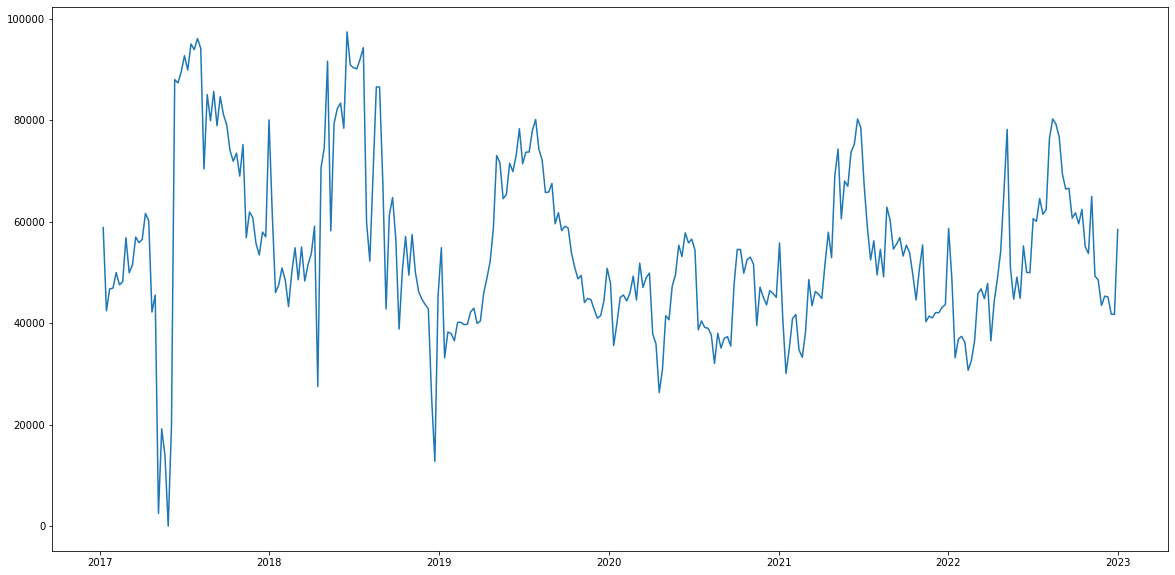

In [131]:
sum_car_forward_within_week = sum_car_forward_within_day.resample('W', closed='left').sum()

plt.figure(figsize=(20,10))
plt.plot(sum_car_forward_within_week.index, sum_car_forward_within_week['count']);

In [ ]:
test = sm.tsa.adfuller(sum_car_forward_within_week['count'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.073804711387901
p-value:  0.028553477672200685
Critical values:  {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}
единичных корней нет, ряд стационарен


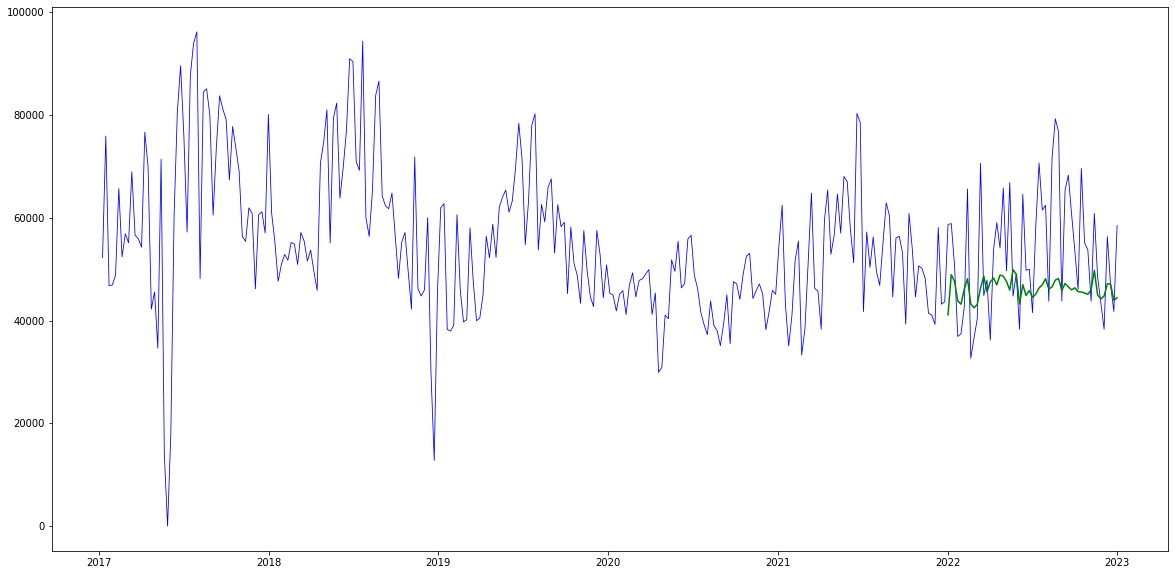

In [ ]:
train, test = train_test_split(sum_car_forward_within_week, train_size=260)

model = pm.auto_arima(train, seasonal=True, m=12*4)
forecasts = model.predict(test.shape[0])

#x = np.arange(y.shape[0])
plt.figure(figsize=(20,10))
plt.plot(sum_car_forward_within_week.index, sum_car_forward_within_week, c='blue', linewidth=0.8)
plt.plot(sum_car_forward_within_week.iloc[260:].index, forecasts, c='green')
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

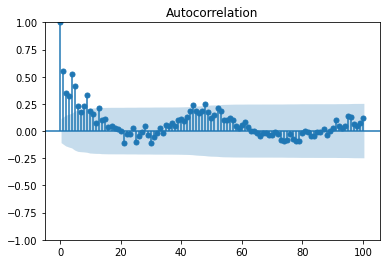

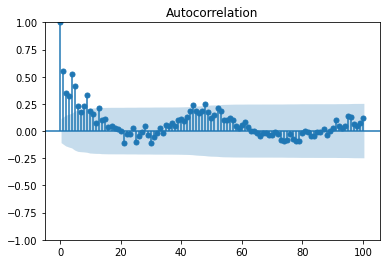

In [ ]:
# plot the auto correlation
plot_acf(sum_car_forward_within_week, lags=100)

In [ ]:
f_48 = forecasts.sum()
test_sum = sum_car_forward_within_week.iloc[260:].values.sum()

MAPE_48 = np.sum(abs(forecasts-sum_car_forward_within_week.iloc[260:].values.reshape(1,-1)[0])/sum_car_forward_within_week.iloc[260:].values.reshape(1,-1)[0])/len(forecasts)
MAPE_48, f_48/test_sum

(0.1741437609646735, 0.8659451942262832)

In [ ]:
skMAPE(sum_car_forward_within_week.iloc[260:].values.reshape(1,-1)[0], forecasts)

0.1741437609646735

# Visualization of car_reverse

In [57]:
car_reverse_for_period = pd.DataFrame({'date': dates, 'count': df_nonan['car_reverse']})
car_reverse_for_period.head()

,date,count
2,2017-01-01,28
3,2017-01-01,41
4,2017-01-01,42
5,2017-01-01,38
6,2017-01-01,46


In [62]:
sum_car_reverse_within_day = car_reverse_for_period.groupby('date').agg({'count': 'sum'})
sum_car_reverse_within_day.head(8)

,count
date,
2017-01-01,3397
2017-01-02,9357
2017-01-03,11902
2017-01-04,12064
2017-01-05,12652
2017-01-06,12226
2017-01-07,13070
2017-01-08,14605


In [67]:
cr_week = sum_car_reverse_within_day.resample('W', closed='left').sum()['count']
cr_week.head()

date
2017-01-08    74668
2017-01-15    56773
2017-01-22    49648
2017-01-29    48138
2017-02-05    49959
Freq: W-SUN, Name: count, dtype: int64

In [68]:
cr_train, cr_test = train_test_split(cr_week, test_size=53)
cr_train.tail(), cr_test.head()

(date
 2021-11-28    46679
 2021-12-05    44947
 2021-12-12    43186
 2021-12-19    44743
 2021-12-26    42440
 Freq: W-SUN, Name: count, dtype: int64,
 date
 2022-01-02    40061
 2022-01-09    68077
 2022-01-16    39435
 2022-01-23    36860
 2022-01-30    36437
 Freq: W-SUN, Name: count, dtype: int64)

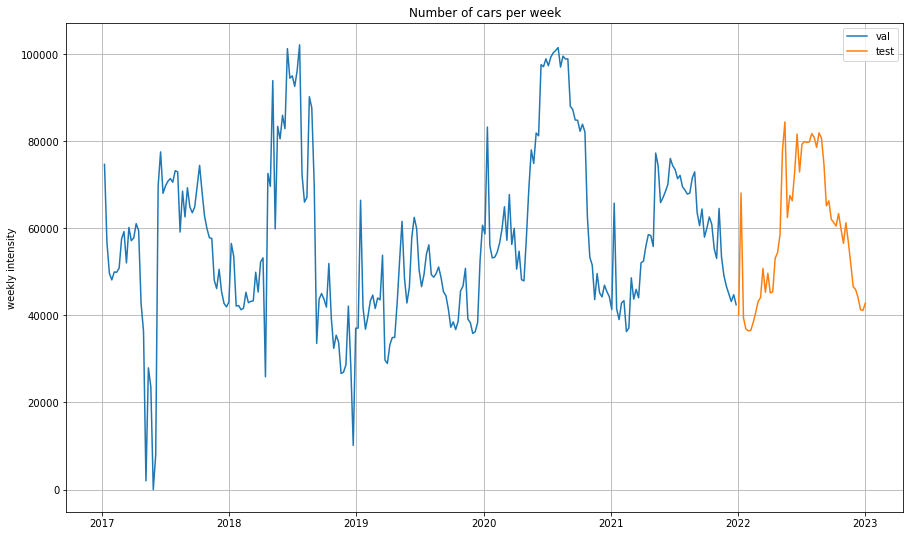

In [69]:
plt.figure(figsize=(15,9))
plt.grid()
plt.title('Number of cars per week')
plt.ylabel('weekly intensity')
plt.plot(cr_train, label='val')
plt.plot(cr_test, label='test')
plt.legend();

In [70]:
check_stationarity(cr_train) # d=0

adf:  -3.28919498759804
p-value:  0.015368421748717028
Critical values:  {'1%': -3.4562572510874396, '5%': -2.8729420379793598, '10%': -2.5728461399461744}
The series is stationary


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


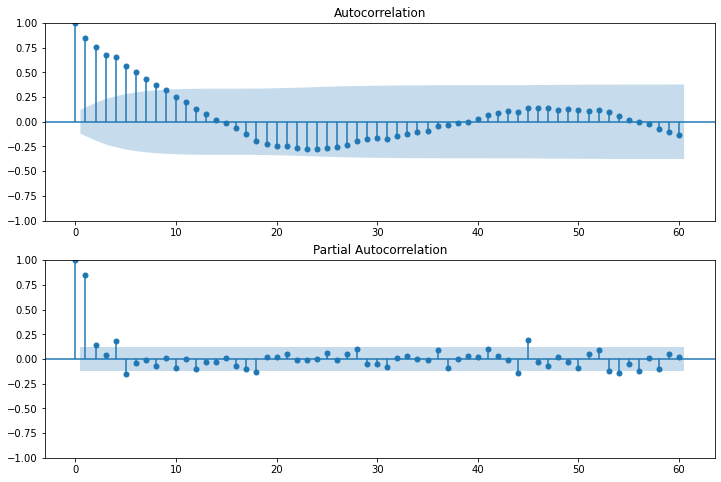

In [71]:
plot_acf_pacf(cr_train)

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


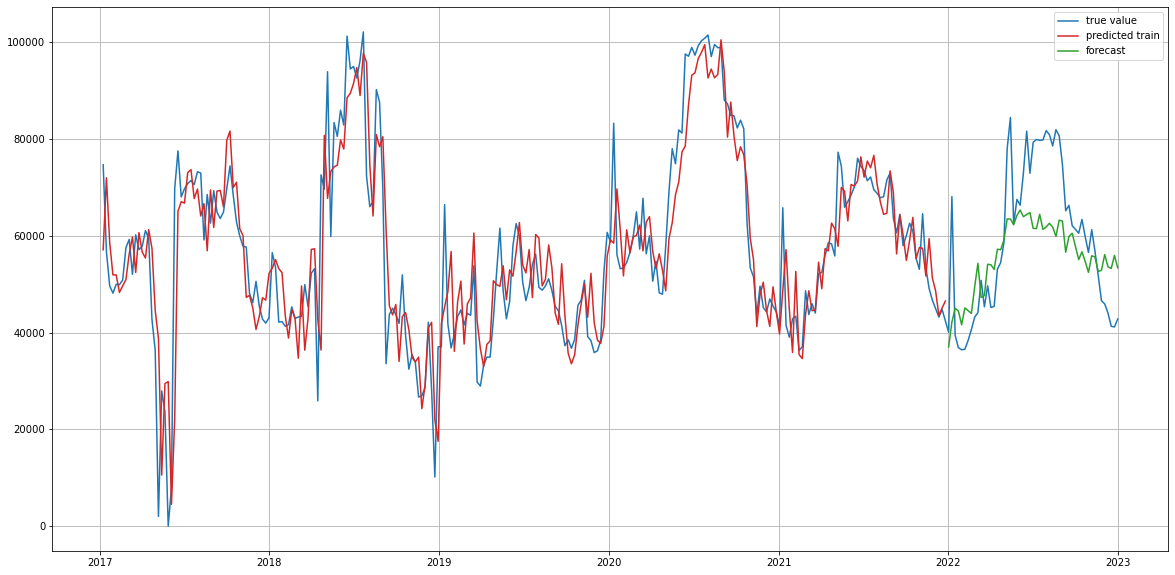

In [73]:
mod_ = ARIMA(endog=cr_train, order=(45,0,9)).fit()
forecast = mod_.forecast(53)
predicted = mod_.predict(-260)

plt.figure(figsize=(20,10))
plt.plot(cr_week, c='tab:blue', label='true value')
plt.plot(cr_train.index, predicted, c='tab:red', label='predicted train')
plt.plot(cr_test.index, forecast, c='tab:green', label='forecast')
plt.legend()
plt.grid()
plt.show()

In [74]:
skMAPE(cr_test,forecast), error_sum(cr_test, forecast)

(0.1494259735089391, '6.216%')

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


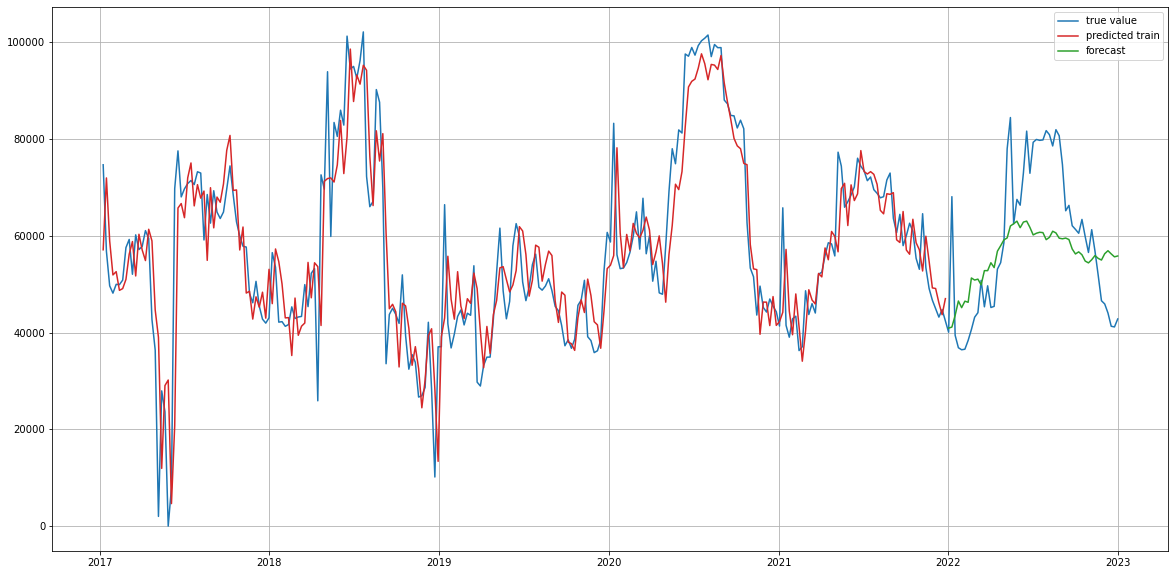

In [99]:
mod_ = ARIMA(endog=cr_train, order=(19,0,9)).fit()
forecast = mod_.forecast(53)
predicted = mod_.predict(-260)

plt.figure(figsize=(20,10))
plt.plot(cr_week, c='tab:blue', label='true value')
plt.plot(cr_train.index, predicted, c='tab:red', label='predicted train')
plt.plot(cr_test.index, forecast, c='tab:green', label='forecast')
plt.legend()
plt.grid()
plt.show()

In [100]:
skMAPE(cr_test,forecast), error_sum(cr_test, forecast)

(0.17051942995680505, '6.162%')

In [101]:
order_cr=(19,0,9)
model_for_cr = ARIMA(endog=cr_week, order=order_cr).fit()

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


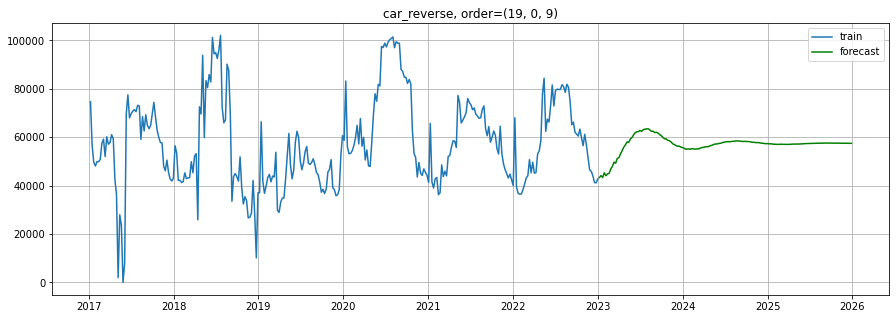

In [102]:
forecast_cr = model_for_cr.forecast(52*3)

plt.figure(figsize=(15,5))
plt.plot(cr_week, c='tab:blue', label='train')
plt.plot(forecast_cr, c='green', label='forecast')
plt.title(f'car_reverse, order={order_cr}')
plt.legend()
plt.grid()
plt.show()

In [95]:
forecast_cr_2023 = forecast_cr.iloc[:52].sum()
forecast_cr_2024 = forecast_cr.iloc[52:104].sum()
forecast_cr_2025 = forecast_cr.iloc[104:].sum()

In [96]:
forecasts_cr = [forecast_cr_2023,forecast_cr_2024,forecast_cr_2025]
years = [2023,2024,2025]
for i in range(3):
    print(f'sum of cars in {years[i]}: {forecasts_cr[i]}')

sum of cars in 2023: 2819475.4557586648
sum of cars in 2024: 2958945.049333202
sum of cars in 2025: 2979084.2866885737
